# Analyse de l'évolution des ventes et des profils clients

## Librairie Lapage

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import datetime

### Importation des données et premier aperçu

In [2]:
customers = pd.read_csv('../Documents/Sana/Data Analyst/P6/DAN-P6-donnees/customers.csv')
customers.head(3)

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984


In [3]:
print("Le dataframe est de la forme", customers.shape)

Le dataframe est de la forme (8623, 3)


In [4]:
products = pd.read_csv('../Documents/Sana/Data Analyst/P6/DAN-P6-donnees/products.csv')
products.head(3)

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0


In [5]:
print("Le dataframe est de la forme", products.shape)

Le dataframe est de la forme (3287, 3)


In [6]:
transactions = pd.read_csv('../Documents/Sana/Data Analyst/P6/DAN-P6-donnees/transactions.csv')
transactions.head(3)

,id_prod,date,session_id,client_id
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714


In [7]:
print("Le dataframe est de la forme", transactions.shape)

Le dataframe est de la forme (679532, 4)


### Préparation des données

On remarque la présence d'un produit d'id T_0 qui a un prix de -1€, des "test_" au niveau des dates et 2 clients test. On décide de supprimer ces références dans les tables.

In [8]:
products[products['id_prod'].str.startswith('T_')]

,id_prod,price,categ
731,T_0,-1.0,0


In [9]:
transactions[transactions['date'].str.startswith('test_')]

,id_prod,date,session_id,client_id
3019,T_0,test_2021-03-01 02:30:02.237419,s_0,ct_0
5138,T_0,test_2021-03-01 02:30:02.237425,s_0,ct_0
9668,T_0,test_2021-03-01 02:30:02.237437,s_0,ct_1
10728,T_0,test_2021-03-01 02:30:02.237436,s_0,ct_0
15292,T_0,test_2021-03-01 02:30:02.237430,s_0,ct_0
...,...,...,...,...
657830,T_0,test_2021-03-01 02:30:02.237417,s_0,ct_0
662081,T_0,test_2021-03-01 02:30:02.237427,s_0,ct_1
670680,T_0,test_2021-03-01 02:30:02.237449,s_0,ct_1
671647,T_0,test_2021-03-01 02:30:02.237424,s_0,ct_1


In [10]:
customers[customers['client_id'].str.startswith('ct_')]

,client_id,sex,birth
2735,ct_0,f,2001
8494,ct_1,m,2001


In [11]:
products = products[~products['id_prod'].str.startswith('T_')]
products.shape

(3286, 3)

In [12]:
transactions = transactions[~transactions['date'].str.startswith('test_')]
transactions.shape

(679332, 4)

In [13]:
customers = customers[~customers['client_id'].str.startswith('ct_')]
customers.shape

(8621, 3)

#### Types de données

In [14]:
customers.dtypes

client_id    object
sex          object
birth         int64
dtype: object

In [15]:
products.dtypes

id_prod     object
price      float64
categ        int64
dtype: object

In [16]:
transactions.dtypes

id_prod       object
date          object
session_id    object
client_id     object
dtype: object

Ici, avoir des ID non numériques n'est a priori pas un problème car on n'a pas d'opération mathématique à réaliser dessus. La seule variable qui doit impérativement être numérique est le prix des produits. La date doit également être formatée.

In [17]:
transactions['date'] = pd.to_datetime(transactions['date'])
transactions.dtypes

id_prod               object
date          datetime64[ns]
session_id            object
client_id             object
dtype: object

#### Valeurs nulles

In [18]:
customers.isnull().sum()

client_id    0
sex          0
birth        0
dtype: int64

In [19]:
products.isnull().sum()

id_prod    0
price      0
categ      0
dtype: int64

In [20]:
transactions.isnull().sum()

id_prod       0
date          0
session_id    0
client_id     0
dtype: int64

Il n'y a aucune valeur nulle dans les données.

#### Valeurs manquantes

In [21]:
customers.isna().sum()

client_id    0
sex          0
birth        0
dtype: int64

In [22]:
products.isna().sum()

id_prod    0
price      0
categ      0
dtype: int64

In [23]:
transactions.isna().sum()

id_prod       0
date          0
session_id    0
client_id     0
dtype: int64

Il n'y a aucune valeur manquante dans les données.

#### Doublons

In [24]:
print("Pourcentage d'id uniques dans la table customers : ", customers['client_id'].unique().shape[0]*100 / customers.shape[0], "%")

Pourcentage d'id uniques dans la table customers :  100.0 %


In [25]:
print("Pourcentage d'id uniques dans la table products : ", products['id_prod'].unique().shape[0]*100 / products.shape[0], "%")

Pourcentage d'id uniques dans la table products :  100.0 %


Les tables ne contiennent pas d'id en double.

### Retravail des variables

Certaines variables (notamment l'année de naissance des clients et les dates de transactions précises à la seconde) ne sont pas utilisables ou pas pertinentes en l'état. Il faut donc retravailler ces variables pour faciliter l'étude statistique.

Cas de la variable birth :

In [26]:
customers['age'] = datetime.datetime.now().year - customers['birth']
customers['age_range'] = pd.qcut(customers['age'].sort_values(), 5)
customers.head(3)

,client_id,sex,birth,age,age_range
0,c_4410,f,1967,55,"(47.0, 59.0]"
1,c_7839,f,1975,47,"(38.0, 47.0]"
2,c_1699,f,1984,38,"(27.0, 38.0]"


Cas de la variable date :

In [27]:
transactions['date'] = transactions['date'].dt.date
transactions['date'] = pd.to_datetime(transactions['date'], format='%Y-%m-%d')
transactions['month'] = transactions['date'].dt.month
transactions['month_year'] = transactions['date'].dt.strftime('%Y-%m')
transactions.head(3)

,id_prod,date,session_id,client_id,month,month_year
0,0_1518,2022-05-20,s_211425,c_103,5,2022-05
1,1_251,2022-02-02,s_158752,c_8534,2,2022-02
2,0_1277,2022-06-18,s_225667,c_6714,6,2022-06


### Fusion des tables

In [28]:
customers_transactions = pd.merge(customers, transactions, on="client_id", how="outer")
customers_transactions.head(3)

,client_id,sex,birth,age,age_range,id_prod,date,session_id,month,month_year
0,c_4410,f,1967,55,"(47.0, 59.0]",0_1316,2021-12-29,s_141762,12.0,2021-12
1,c_4410,f,1967,55,"(47.0, 59.0]",1_385,2021-03-22,s_9707,3.0,2021-03
2,c_4410,f,1967,55,"(47.0, 59.0]",1_190,2021-11-12,s_118628,11.0,2021-11


Cette table présente chaque achat de chaque client (+ les clients qui n'ont rien acheté).

In [29]:
products_transactions = pd.merge(transactions, products, on="id_prod", how="outer").fillna(value = {'client_id' : 0})
products_transactions.head(3)

,id_prod,date,session_id,client_id,month,month_year,price,categ
0,0_1518,2022-05-20,s_211425,c_103,5.0,2022-05,4.18,0.0
1,0_1518,2021-09-26,s_95811,c_6197,9.0,2021-09,4.18,0.0
2,0_1518,2021-05-06,s_30782,c_682,5.0,2021-05,4.18,0.0


Celle-ci montre chaque vente de chaque produit (+ les produits qui n'ont pas été vendus).

On réalise des jointures externes pour ne pas perdre d'information.

In [30]:
print("Il y a ", products_transactions['price'].isnull().sum(), " valeurs de prix et ", products_transactions['categ'].isnull().sum(), "valeurs de catégorie manquantes parmi les produits vendus.")

Il y a  221  valeurs de prix et  221 valeurs de catégorie manquantes parmi les produits vendus.


In [31]:
print("Ces ventes concernent : ", products_transactions[products_transactions['price'].isnull()]['id_prod'].unique().shape[0], " produit(s).")

Ces ventes concernent :  1  produit(s).


Nous allons récupérer l'id de ce produit, et remplir sa valeur de prix par la médiane et de catégorie par la valeur la plus représentée.

In [32]:
id_prod_manquant = products_transactions[products_transactions['price'].isnull()]['id_prod'].unique()[0]
products.loc[len(products.index)] = [id_prod_manquant, products['price'].median(), 0]
products.loc[len(products.index)]

id_prod    0_2245
price      13.075
categ           0
Name: 3286, dtype: object

### Calcul du chiffre d'affaires

On va déterminer le chiffre d'affaires par date, en calculant la somme des prix sur un dataframe regroupé par date. Si un produit est vendu plusieurs fois à la même date, cela va naturellement multiplier son prix par le nombre de ventes.

In [33]:
tmp = products_transactions.groupby('month_year')['price'].agg(np.sum)
CA_par_date = pd.DataFrame(tmp).rename(columns = {'price' : 'CA'})
CA_par_date = pd.merge(products_transactions, CA_par_date, on="month_year")[['month_year', 'month', 'CA']]
CA_par_date.sort_values(by="month_year", inplace=True)
CA_par_mois = CA_par_date.groupby('month')['CA'].agg(np.mean).to_frame()
CA_par_date = CA_par_date.groupby('month_year')['CA'].agg(np.mean).to_frame()
CA_par_date.head(3)

,CA
month_year,
2021-03,482440.61
2021-04,476109.30
2021-05,492943.47


In [34]:
print("Et le chiffre d'affaires total réalisé sur cette période est de : ", CA_par_date['CA'].sum(), "euros.")

Et le chiffre d'affaires total réalisé sur cette période est de :  11853728.68 euros.


### Evolution temporelle du CA

Nous allons maintenant analyser l'évolution temporelle du chiffre d'affaires.

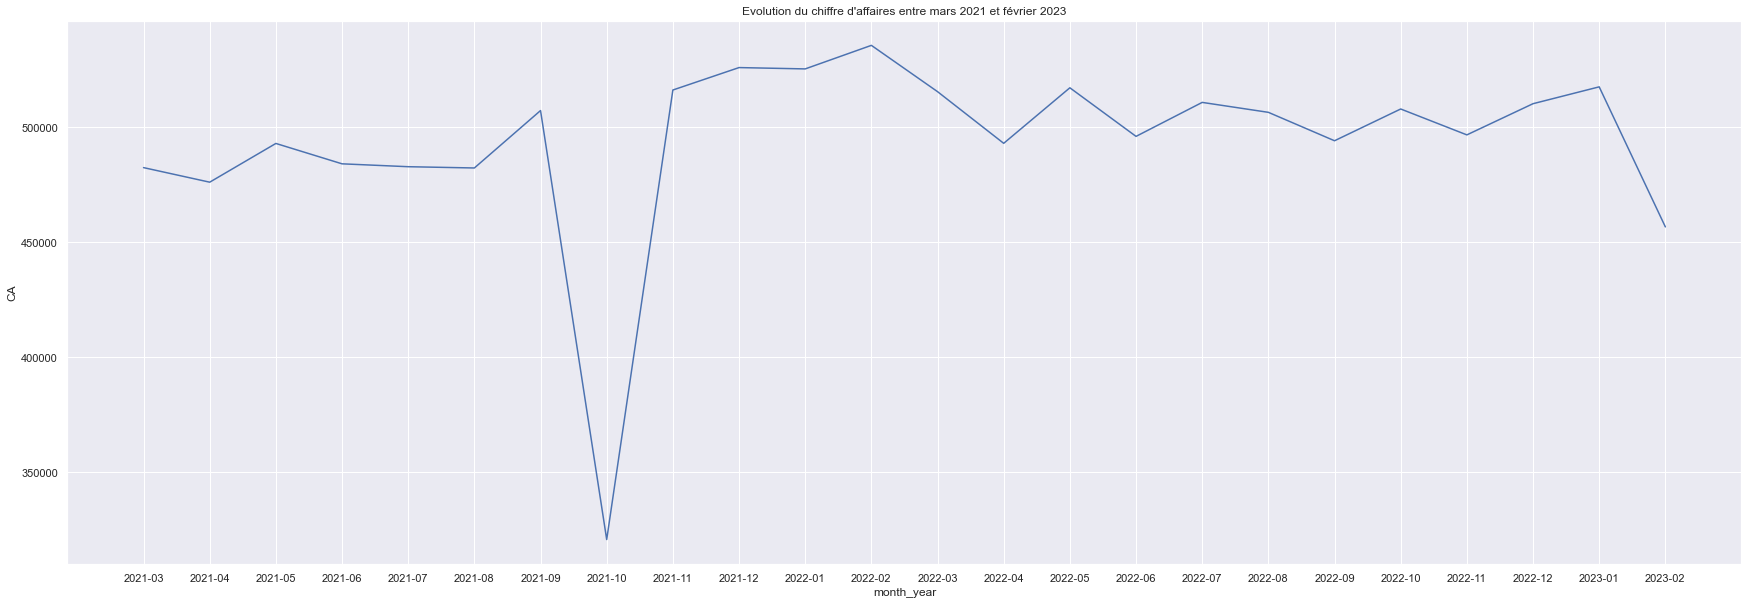

In [35]:
sns.set(rc={"figure.figsize":(30, 10)})
sns.lineplot(data = CA_par_date, y = 'CA', x = 'month_year')
plt.title("Evolution du chiffre d'affaires entre mars 2021 et février 2023")
plt.show()

On remarque une baisse importante du CA sur le mois d'octobre 2021, et une tendance relativement stable le reste du temps. Une baisse se dessine également sur le dernier mois.

Intéressons-nous à ce qui s'est passé au mois d'octobre 2021 :

In [82]:
CA_par_date.reset_index(inplace=True)
CA_par_date.head(3)

,month_year,CA,RM3,RM6
0,2021-03,482440.61,NaN,NaN
1,2021-04,476109.30,NaN,NaN
2,2021-05,492943.47,483831.126667,NaN
3,2021-06,484088.56,484380.443333,NaN
4,2021-07,482835.40,486622.476667,NaN
5,2021-08,482284.79,483069.583333,483450.355000
6,2021-09,507240.68,490786.956667,487583.700000
7,2021-10,320798.74,436774.736667,461698.606667
8,2021-11,516167.73,448069.050000,465569.316667
9,2021-12,525917.28,454294.583333,472540.770000


In [83]:
tmp = pd.merge(CA_par_date, products_transactions, on="month_year")
oct_21_categ_count = tmp[tmp['month_year'] == '2021-10'].groupby('categ')['categ'].count()
oct_21_categ_count

categ
0.0    18762
1.0     1666
2.0     1171
Name: categ, dtype: int64

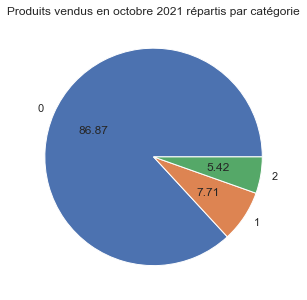

In [84]:
plt.pie(np.array(oct_21_categ_count), labels = ['0', '1', '2'], autopct = '%.2f')
plt.title("Produits vendus en octobre 2021 répartis par catégorie")
plt.show()

En mettant en perspective ce graphique et celui de la répartition du chiffre d'affaires par catégorie ci-après, on observe que la répartition est similaire ce mois-ci comparé à la tendance globale. Ainsi, on peut en déduire que la baisse de ce mois-ci n'est pas due à une rupture de stock, par exemple (ce qui aurait pu être le cas si une catégorie qui génère habituellement beaucoup de chiffre d'affaires était à un faible pourcentage), mais simplement à une baisse des ventes générale.

Analysons la tendance au sein d'une année :

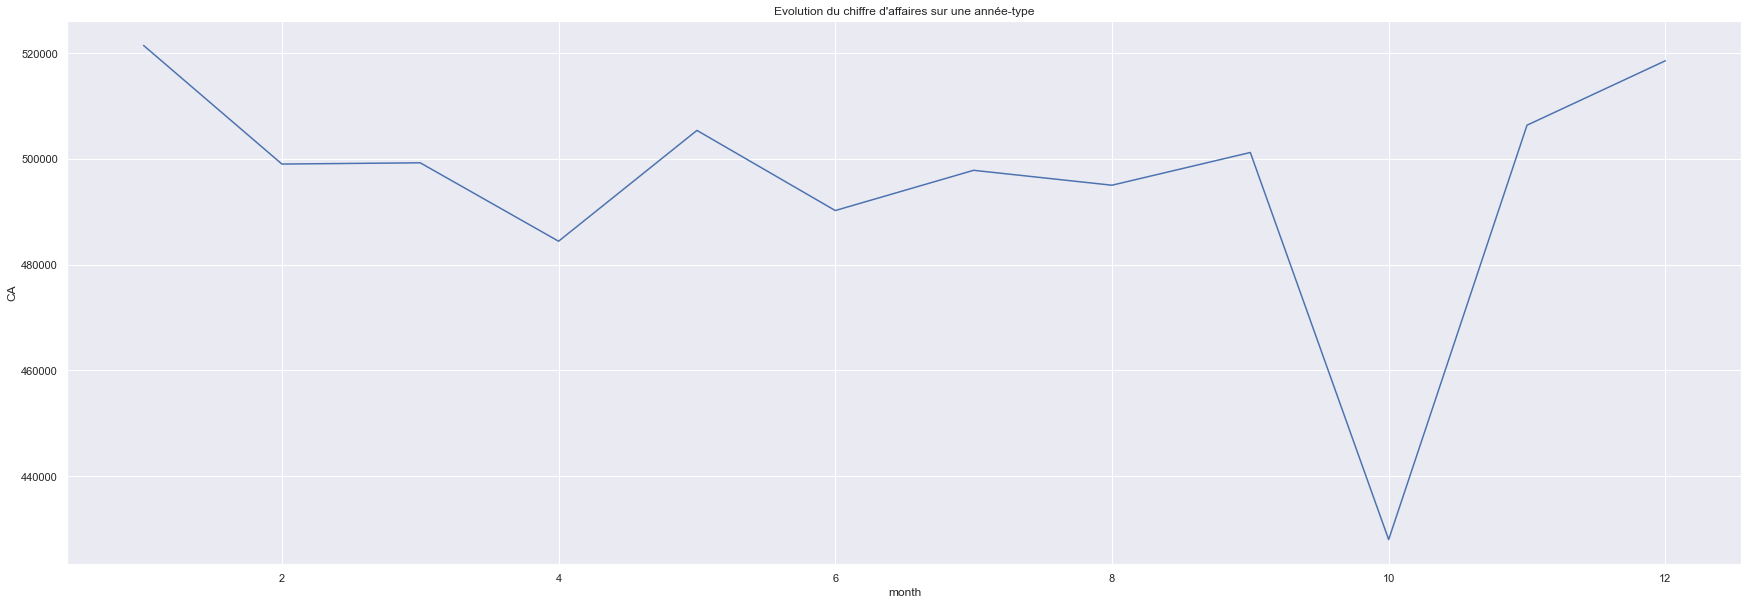

In [39]:
sns.lineplot(data = CA_par_mois, y = 'CA', x = 'month')
plt.title("Evolution du chiffre d'affaires sur une année-type")
plt.show()

D'une manière plus globale, le mois d'octobre semble être un mois creux (mais le pic est biaisé par le mois d'octobre 2021 qui était particulièrement creux) et les mois les plus rentables sont janvier et décembre, pendant les fêtes de fin d'année.

Nous allons utiliser la décomposition en moyenne mobile (sur 3 et 6 mois) pour avoir une tendance plus globale du chiffre d'affaires :

In [40]:
CA_par_date['RM3'] = CA_par_date['CA'].rolling(3).mean()
CA_par_date['RM6'] = CA_par_date['CA'].rolling(6).mean()

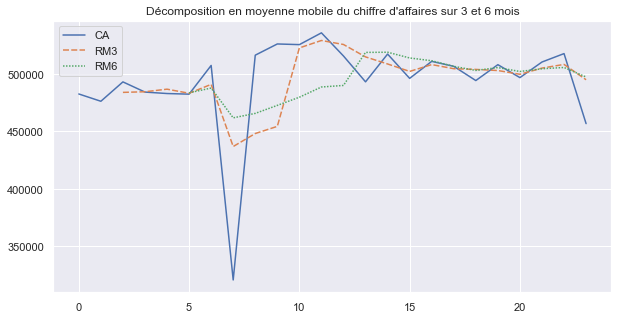

In [85]:
sns.lineplot(data = CA_par_date)
plt.title("Décomposition en moyenne mobile du chiffre d'affaires sur 3 et 6 mois")
plt.show()

La décomposition en moyennes mobiles permet d'observer une tendance plus globale du chiffre d'affaires, moins influencée par le bruit (c'est-à-dire les variations non significatives). Ainsi, on voit une tendance globale du chiffre d'affaires relativement stable, qui avoisine les 500 000 euros.

### Zoom sur les références

Nous allons avoir besoin d'un dataframe qui calcule le chiffre d'affaires par produit.

In [42]:
tmp = products_transactions[products_transactions['client_id'] != 0].groupby('id_prod')['id_prod'].count()
ventes_par_produit = pd.DataFrame(tmp).rename(columns = {'id_prod' : 'total_sales'})
tmp = products[['id_prod', 'price', 'categ']]
CA_par_produit = pd.merge(ventes_par_produit, tmp, on="id_prod")
CA_par_produit['CA'] = CA_par_produit['price'] * CA_par_produit['total_sales']
CA_par_produit.sort_values(by="CA", inplace=True)
CA_par_produit.head(3)

,id_prod,total_sales,price,categ,CA
595,0_1539,1,0.99,0,0.99
313,0_1284,1,1.38,0,1.38
719,0_1653,2,0.99,0,1.98


### Répartition du chiffre d'affaires par produit

Nous allons analyser la répartition du chiffre d'affaires entre les différents produits à l'aide d'une courbe de Lorenz :

In [43]:
CA_par_produit['CA_cum'] = CA_par_produit['CA'].cumsum()/(CA_par_produit['CA'].sum())
CA_par_produit

,id_prod,total_sales,price,categ,CA,CA_cum
595,0_1539,1,0.99,0,0.99,8.349838e-08
313,0_1284,1,1.38,0,1.38,1.998901e-07
719,0_1653,2,0.99,0,1.98,3.668868e-07
2079,0_807,1,1.99,0,1.99,5.347270e-07
665,0_1601,1,1.99,0,1.99,7.025672e-07
...,...,...,...,...,...,...
3152,2_209,814,69.99,2,56971.86,9.755094e-01
3034,2_102,1027,59.14,2,60736.78,9.806321e-01
3045,2_112,968,67.57,2,65407.76,9.861487e-01
3070,2_135,1005,68.99,2,69334.95,9.919965e-01


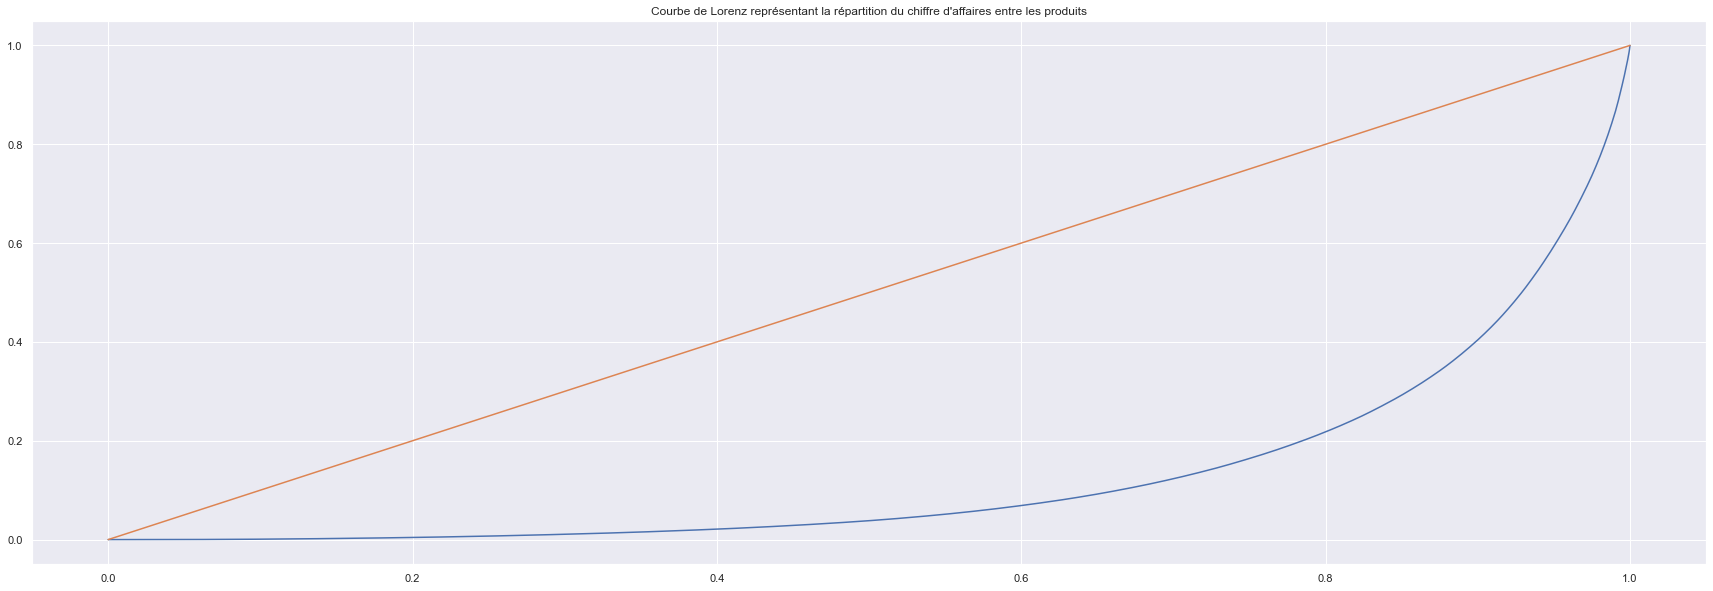

In [44]:
xaxis = np.linspace(0, 1, len(CA_par_produit))
plt.plot(xaxis, CA_par_produit['CA_cum'])
plt.plot(xaxis, xaxis)
plt.title("Courbe de Lorenz représentant la répartition du chiffre d'affaires entre les produits")
plt.show()

On voit que la répartition est très hétérogène : il semblerait que 80% des produits ne génèrent qu'environ 20% du chiffre d'affaires tandis que les 20% restants en génèrent les 80% restants.

On calcule l'indice de Gini pour compléter la courbe de Lorenz :

In [45]:
AUC = (CA_par_produit['CA_cum'].sum() -CA_par_produit['CA_cum'][-1:] -CA_par_produit['CA_cum'][0])/len(CA_par_produit)
S = 0.5 - AUC
gini = 2*S
print("L'indice de Gini est de : ", round(gini, 3)[3096])

L'indice de Gini est de :  0.743


L'indice de Gini se rapproche de 1 et vient confirmer l'observation que la distribution est très inéquitable.

#### Top ventes

On reprend cette table, que l'on trie par chiffre d'affaires décroissant et dont on prend les 10 premières références. On réalise un pie chart des catégories des livres les plus vendus :

In [46]:
top_10 = CA_par_produit.sort_values(by="CA", ascending=False).head(10)
top_10[['id_prod', 'CA']]

,id_prod,CA
3096,2_159,94893.50
3070,2_135,69334.95
3045,2_112,65407.76
3034,2_102,60736.78
3152,2_209,56971.86
2619,1_395,54356.25
2591,1_369,54025.48
3043,2_110,53846.25
3201,2_39,53060.85
3104,2_166,52449.12


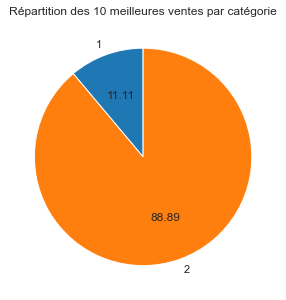

In [47]:
top_10_categ = top_10.groupby('categ')['categ'].agg(np.sum)
sns.set(rc={"figure.figsize":(5, 5)})
plt.pie(np.array(top_10_categ), labels = ['1', '2'], colors = sns.color_palette("tab10"), autopct='%.2f', startangle=90)
plt.title("Répartition des 10 meilleures ventes par catégorie")
plt.show()

On voit que le chiffre d'affaires généré par les 10 meilleures ventes est à 89% généré par les livres de catégorie 2.

#### Flops

Ici, on classe par catégorie les produits répertoriés dans le tableau des ventes mais qui n'ont pas été vendus (auxquels on a appliqué un client_id = 0)

In [48]:
flops = pd.DataFrame(products_transactions[products_transactions['client_id'] == 0][['id_prod', 'price', 'categ']])
flops[['id_prod', 'categ']]

,id_prod,categ
679332,0_1016,0.0
679333,0_1780,0.0
679334,0_1062,0.0
679335,0_1119,0.0
679336,0_1014,0.0
679337,1_0,1.0
679338,0_1318,0.0
679339,0_1800,0.0
679340,0_1645,0.0
679341,0_322,0.0


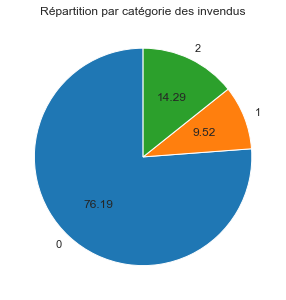

In [49]:
flops_categ = flops.groupby('categ')['categ'].count()
plt.pie(np.array(flops_categ), labels = ['0', '1', '2'], colors = sns.color_palette("tab10"), autopct='%.2f', startangle=90)
plt.title("Répartition par catégorie des invendus")
plt.show()

Parmi les invendus, 76% sont de catégorie 0, et 14% sont de catégorie 2.

#### Répartition par catégorie

Répartition du CA : 

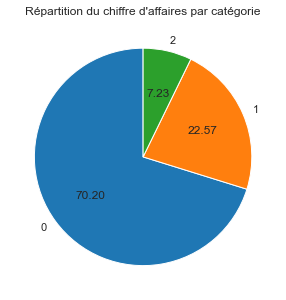

In [50]:
CA_par_categ = CA_par_produit.groupby('categ')['categ'].count()
plt.pie(np.array(CA_par_categ), labels = ['0', '1', '2'], colors = sns.color_palette("tab10"), autopct='%.2f', startangle=90)
plt.title("Répartition du chiffre d'affaires par catégorie")
plt.show()

On voit que le chiffre d'affaires est généré à 70% par la catégorie 0, et à 23% par la catégorie 1.

### Profil des clients

Répartition des clients par sexe :

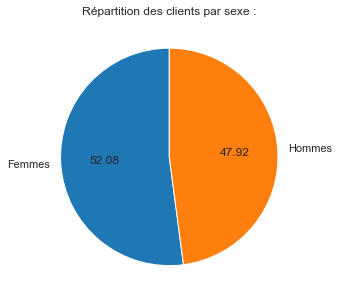

In [51]:
repart_sex = np.array([customers[customers['sex'] == 'f'].count()[1], customers[customers['sex'] == 'm'].count()[1]])
plt.pie(repart_sex, labels = ['Femmes', 'Hommes'], colors = sns.color_palette("tab10"), autopct='%.2f', startangle=90)
plt.title('Répartition des clients par sexe :')
plt.show()

On observe que les clients sont équitablement répartis entre hommes et femmes.

Répartition des clients par année de naissance :

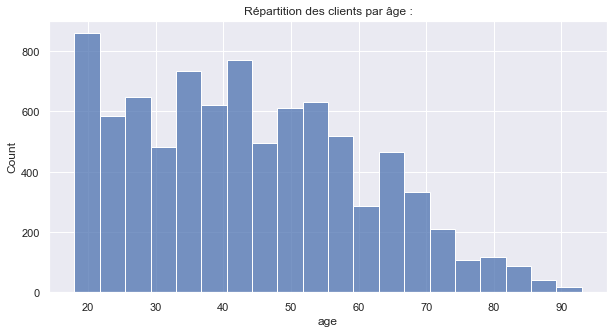

In [52]:
sns.set(rc={"figure.figsize":(10, 5)})
sns.histplot(customers['age'], bins = 20)
plt.title("Répartition des clients par âge :")
plt.show()

In [53]:
customers['age'].describe()

count    8621.000000
mean       43.724394
std        16.917958
min        18.000000
25%        30.000000
50%        43.000000
75%        56.000000
max        93.000000
Name: age, dtype: float64

On observe que les clients ont entre 18 et 93 ans, que la moyenne d'âge est de 44 ans et que la moitié des clients ont entre 30 et 56 ans. De plus, on remarque la répartition un peu plus importante autour des 40 ans et l'âge le plus représenté est d'environ 20 ans.

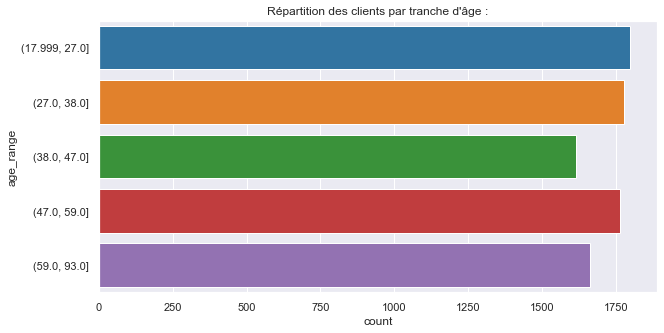

In [54]:
sns.countplot(y = customers['age_range'], palette = sns.color_palette("tab10"))
plt.title("Répartition des clients par tranche d'âge :")
plt.show()

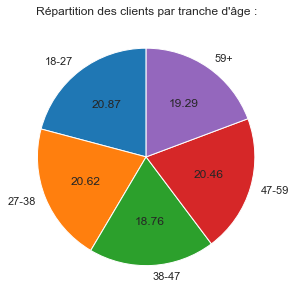

In [55]:
repart_tranche_age = customers.groupby('age_range')['age_range'].count()
plt.pie(np.array(repart_tranche_age), labels = ['18-27', '27-38', '38-47', '47-59', '59+'], colors = sns.color_palette("tab10"), autopct='%.2f', startangle=90)
plt.title("Répartition des clients par tranche d'âge :")
plt.show()

En revanche, l'analyse par tranches d'âge montre que chacune d'elles est équitablement représentée parmi les clients, avec environ 20% pour chaque tranche d'âge.

### Répartition du CA entre les clients

Nous allons avoir besoin d'un dataframe qui calcule le chiffre d'affaires généré par client :

In [56]:
tmp = pd.merge(customers_transactions, products, on="id_prod")
CA_par_client = pd.DataFrame(tmp.groupby('client_id')['price'].agg(np.sum)).rename(columns = {'price' : 'CA'})
CA_par_client = pd.merge(customers, CA_par_client, on="client_id")[['client_id', 'CA']].sort_values(by="CA")
CA_par_client.head(3)

,client_id,CA
2169,c_8351,6.31
2717,c_8140,8.30
2462,c_8114,9.98


Nous allons maintenant utiliser une courbe de Lorenz pour représenter la répartition du chiffre d'affaires par client.

In [57]:
CA_par_client['CA_cum'] = (CA_par_client['CA'].cumsum())/(CA_par_client['CA'].sum())
CA_par_client.head(3)

,client_id,CA,CA_cum
2169,c_8351,6.31,5.321967e-07
2717,c_8140,8.30,1.232234e-06
2462,c_8114,9.98,2.073965e-06


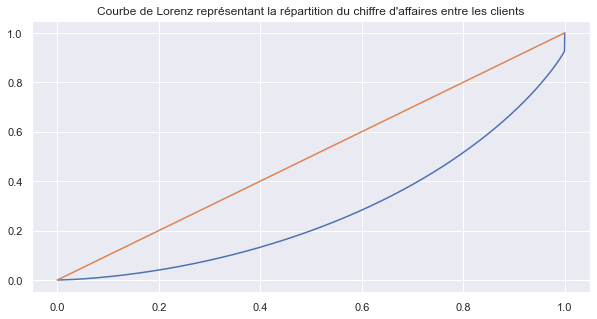

In [58]:
xaxis = np.linspace(0, 1, len(CA_par_client))
plt.figure(figsize = (10, 5))
plt.plot(xaxis, CA_par_client['CA_cum'])
plt.plot(xaxis, xaxis)
plt.title("Courbe de Lorenz représentant la répartition du chiffre d'affaires entre les clients")
plt.show()

On peut observer que la courbe bleue est relativement loin de la bissectrice. Cela signifie que le chiffre d'affaires est inéquitablement réparti entre les clients.

On calcule l'indice de Gini pour compléter la courbe de Lorenz :

In [59]:
AUC = (CA_par_client['CA_cum'].sum() -CA_par_client['CA_cum'][-1:] -CA_par_client['CA_cum'][0])/len(CA_par_client)
S = 0.5 - AUC
gini = 2*S
print("L'indice de Gini est de : ", round(gini, 3)[3633])

L'indice de Gini est de :  0.447


L'indice de Gini témoigne d'une répartition assez hétérogène du chiffre d'affaires entre les clients. Pour une équité parfaite, il serait égal à 0, or il est ici de 0.4.

### Analyse des outliers

On remarque sur la courbe de Lorenz que quelques clients représentent une proportion non-négligeable du chiffre d'affaires. On s'intéresse à ces outliers pour une étude spécifique :

On commence par les mettre en évidence :

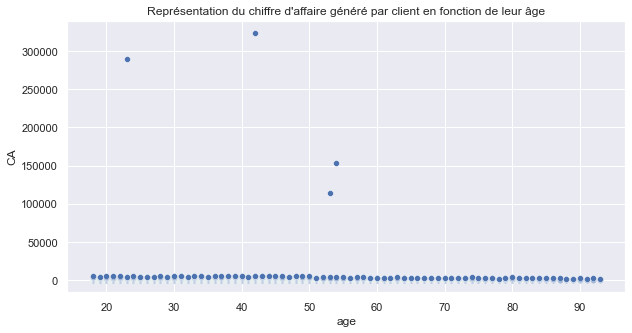

In [61]:
tmp = pd.merge(CA_par_client, customers, on="client_id")[['client_id', 'CA', 'age']]
sns.scatterplot(data = tmp, x = 'age', y = 'CA')
plt.title("Représentation du chiffre d'affaire généré par client en fonction de leur âge")
plt.show()

In [62]:
clients_outliers = tmp[tmp['CA'] >= 100000]
clients_outliers

,client_id,CA,age
8596,c_3454,113677.155,53
8597,c_6714,153677.370,54
8598,c_4958,289760.340,23
8599,c_1609,324033.350,42


On a quatre clients outliers.

In [63]:
tmp = pd.merge(clients_outliers, customers, on="client_id", how="left").drop(columns = ['age_y', 'birth', 'age_range']).rename(columns = {'age_x' : 'age'})
tmp

,client_id,CA,age,sex
0,c_3454,113677.155,53,m
1,c_6714,153677.370,54,f
2,c_4958,289760.340,23,m
3,c_1609,324033.350,42,m


On observe que parmi eux, on a 3 hommes et 1 femme, un client de 23 ans et le reste ayant plus de 40 ans (dont 2 ayant plus de 50 ans).

In [64]:
tmp = pd.merge(tmp, products_transactions, on="client_id", how="left")[['client_id', 'CA', 'age', 'sex', 'price', 'categ']]
tmp

,client_id,CA,age,sex,price,categ
0,c_3454,113677.155,53,m,4.18,0.0
1,c_3454,113677.155,53,m,4.18,0.0
2,c_3454,113677.155,53,m,4.18,0.0
3,c_3454,113677.155,53,m,4.18,0.0
4,c_3454,113677.155,53,m,4.18,0.0
...,...,...,...,...,...,...
46638,c_1609,324033.350,42,m,2.99,0.0
46639,c_1609,324033.350,42,m,1.99,0.0
46640,c_1609,324033.350,42,m,8.30,0.0
46641,c_1609,324033.350,42,m,2.99,0.0


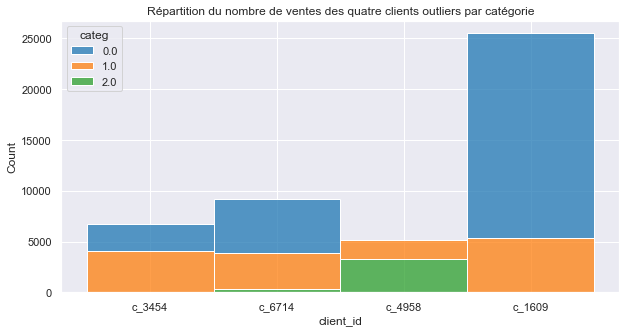

In [65]:
sns.histplot(tmp, x = 'client_id', hue='categ', multiple='stack', palette='tab10')
plt.title("Répartition du nombre de ventes des quatre clients outliers par catégorie")
plt.show()

Premièrement, on peut voir que ce sont les fréquences d'achat qui sont inhabituellement élevées chez ces clients, et particulièrement le dernier. Ensuite, on observe un comportement différent entre le client le plus jeune, qui achète des livres de catégorie 2 et peu de catégorie 1, et les autres, qui achètent un volume comparable de livres de catégorie 1 et également de la catégorie 0 en proportions variables.

In [66]:
print("Ces clients génèrent ", round(clients_outliers['CA'].sum()*100 / CA_par_client['CA'].sum(), 2), "% du chiffre d'affaires total.")

Ces clients génèrent  7.43 % du chiffre d'affaires total.


### Préparations des variables d'intérêt

On commence par préparer des dataframes avec les variables dont on va avoir besoin, en prenant soin de retirer les outliers (dont l'étude a déjà été faite séparément) :

In [67]:
CA_par_client = CA_par_client[~CA_par_client['client_id'].isin(clients_outliers['client_id'])]

In [68]:
tmp = pd.merge(customers_transactions, CA_par_client, on="client_id", how="right")
df = pd.merge(tmp, products, on="id_prod")
df_categ = df.groupby(['client_id', 'categ'])['age'].agg(['mean', 'count']).rename(columns = {'mean' : 'age'})
df_categ.reset_index(inplace=True)
df_categ = pd.merge(df_categ, customers, on="client_id")[['client_id', 'categ', 'sex', 'age_y', 'count']].rename(columns = {'age_y' : 'age'})
df_categ.head(3)

,client_id,categ,sex,age,count
0,c_1,0,m,67,30
1,c_1,1,m,67,8
2,c_1,2,m,67,1


In [69]:
tmp = pd.merge(customers_transactions, CA_par_client, on="client_id", how="right")
df = pd.merge(tmp, products, on="id_prod")
df = df[['client_id', 'age', 'CA']]
df.rename(columns = {'CA' : 'total_amount'}, inplace=True)
tmp = df.groupby('client_id')['client_id'].count().to_frame().rename(columns = {'client_id' : 'sales_freq'})
df = pd.merge(tmp, df, on="client_id")
df = df.groupby('client_id')[['sales_freq', 'age', 'total_amount']].agg(np.mean)
df_montant_freq = df
df_montant_freq.head(3)

,sales_freq,age,total_amount
client_id,,,
c_1,39.0,67.0,558.18
c_10,58.0,66.0,1353.60
c_100,8.0,30.0,254.85


In [70]:
tmp = pd.merge(customers_transactions, CA_par_client, on="client_id", how="right")
df = pd.merge(tmp, products, on="id_prod")
df.groupby('session_id')['price'].agg(np.mean)
tmp = df.groupby(['client_id', 'session_id'])['price'].agg(np.sum).to_frame().rename(columns = {'price' : 'cart'})
df = tmp.groupby('client_id')['cart'].agg(np.mean).to_frame().rename(columns = {'cart' : 'avg_cart'})
df_age_avg = pd.merge(customers, df, on="client_id")[['client_id', 'age', 'avg_cart']]
df_age_avg.head(3)

,client_id,age,avg_cart
0,c_4410,55,26.477308
1,c_7839,47,29.206842
2,c_1699,38,31.766667


### Analyse des corrélations

#### Lien entre le genre d'un client et les catégories de livres achetés :

Ici, on recherche une corrélation entre deux variables qualitatives. Commençons par une représentation graphique :

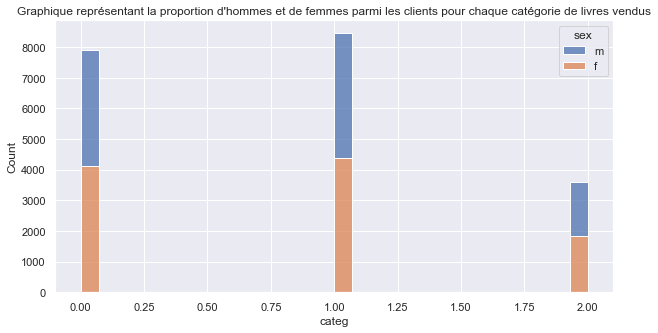

In [71]:
sns.histplot(df_categ, x = 'categ', hue='sex', multiple='stack')
plt.title("Graphique représentant la proportion d'hommes et de femmes parmi les clients pour chaque catégorie de livres vendus")
plt.show()

A priori, les proportions homme/femme semblent constantes quelle que soit la catégorie de livre. Cela signifie qu'on n'attend pas de corrélation entre ces deux variables. Nous allons vérifier cela à l'aide du test statistique du chi-deux.

In [72]:
pg.chi2_independence(df_categ, x = 'categ', y = 'sex')[2]

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,1.024728,2.0,0.599078,0.007170,0.134916
1,cressie-read,0.666667,1.024649,2.0,0.599101,0.007170,0.134909
2,log-likelihood,0.000000,1.024501,2.0,0.599146,0.007169,0.134896
3,freeman-tukey,-0.500000,1.024398,2.0,0.599177,0.007169,0.134886
4,mod-log-likelihood,-1.000000,1.024303,2.0,0.599205,0.007168,0.134878
5,neyman,-2.000000,1.024134,2.0,0.599256,0.007168,0.134863


On voit que la p-valeur est toujours bien supérieure à 5%, ainsi on ne rejette pas l'hypothèse que les deux variables sont indépendantes. Il n'y a pas de lien entre le genre d'un client et les catégories de livres qu'il achète.

#### Lien entre l'âge des clients et les catégories des livres achetés :

On commence par une représentation graphique :

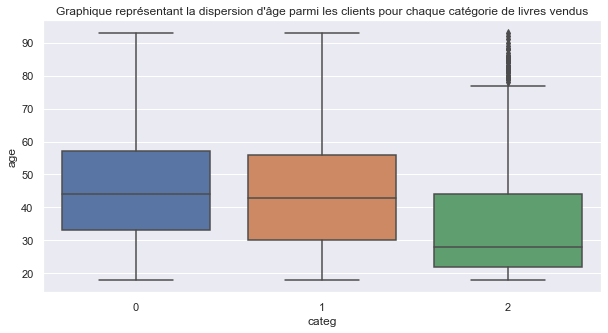

In [73]:
sns.boxplot(data = df_categ, x = 'categ', y = 'age')
plt.title("Graphique représentant la dispersion d'âge parmi les clients pour chaque catégorie de livres vendus")
plt.show()

On voit que les trois boîtes ne sont pas identiques, cela signifie qu'il peut potentiellement y avoir une corrélation entre les variables age et categ. Pour savoir quel test statistique il est bon d'utiliser ici, on se doit de vérifier la normalité et l'homoscédasticité de la distribution :

In [74]:
pg.normality(data = df_categ, dv = 'age', group = 'categ')

C:\Users\sanat_avvxgog\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,W,pval,normal
0,0.979657,4.204658e-32,False
1,0.970726,2.692415e-38,False
2,0.859387,0.000000e+00,False


On voit ici que la distribution de l'âge n'est pas normale. Ainsi, on ne peut utiliser le test par ANOVA, on préférera le test de Kruskal-Wallis.

In [75]:
pg.kruskal(data = df_categ, dv = 'categ', between = 'age')

,Source,ddof1,H,p-unc
Kruskal,age,75,1400.149958,3.013879e-243


On a ici une p-valeur extrêmement faible, ce qui indique que les variables âge et catégorie sont corrélées. Il semblerait que les clients plus jeunes s'orientent vers la catégorie 2, et que les clients plus âgés se répartissent entre les catégories 0 et 1.

#### Lien entre l'âge des clients et le montant total des achats :

On cherche ici une corrélation entre deux variables quantitatives. On commence par une représentation graphique :

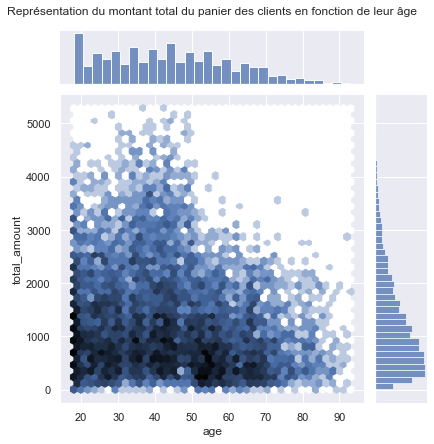

In [76]:
sns.jointplot(data = df_montant_freq, x = 'age', y = 'total_amount', kind="hex", joint_kws={'gridsize':40, 'bins':'log'})
plt.title("Représentation du montant total du panier des clients en fonction de leur âge", pad=80)
plt.show()

On peut distinguer une légère corrélation entre les deux variables ici, du fait qu'elles semblent décroître ensemble.

On calcule le coefficient de corrélation de Pearson :

In [77]:
pg.corr(df_montant_freq['age'], df_montant_freq['total_amount'])

,n,r,CI95%,p-val,BF10,power
pearson,8596,-0.188308,"[-0.21, -0.17]",1.918728e-69,3.096e+65,1.0


On voit que la p-valeur est très petite. Cela signifie que l'on rejette l'hypothèse d'indépendance, et qu'il y a bien une corrélation linéaire entre l'âge des clients et le montant total des paniers.

#### Lien entre l'âge des clients et la fréquence d'achat :

On commence par une représentation graphique :

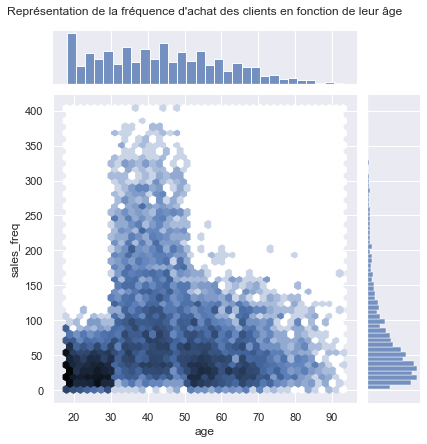

In [78]:
sns.jointplot(data = df_montant_freq, x = 'age', y = 'sales_freq', kind="hex", joint_kws={'gridsize':40, 'bins':'log'})
plt.title("Représentation de la fréquence d'achat des clients en fonction de leur âge", pad=80)
plt.show()

Ici aussi, les variables semblent décroître ensemble.

On réalise un test de corrélation linéaire :

In [79]:
pg.corr(df_montant_freq['age'], df_montant_freq['sales_freq'])

,n,r,CI95%,p-val,BF10,power
pearson,8596,0.030439,"[0.01, 0.05]",0.004767,0.725,0.805843


Ici, on observe que la p-valeur est bien inférieure à 0.05. On peut en déduire que l'âge des clients et leur fréquence d'achat sont corrélées.

#### Lien entre l'âge des clients et la taille du panier moyen :

On commence par une représentation graphique :

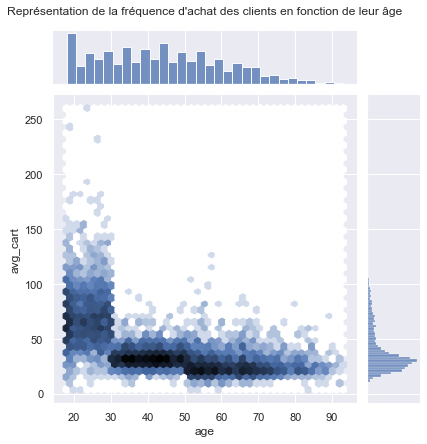

In [80]:
sns.jointplot(data = df_age_avg, x = 'age', y = 'avg_cart', kind="hex", joint_kws={'gridsize':40, 'bins':'log'})
plt.title("Représentation de la fréquence d'achat des clients en fonction de leur âge", pad=80)
plt.show()

D'une certaine manière, la même observation d'une double-décroissance peut être faite ici.

On réalise un test de corrélation linéaire :

In [81]:
pg.corr(df_age_avg['age'], df_age_avg['avg_cart'])

,n,r,CI95%,p-val,BF10,power
pearson,8596,-0.616911,"[-0.63, -0.6]",0.0,inf,1.0


Ici, la p-valeur est égale à  0. Cela signifie qu'il y a un lien de corrélation entre l'âge des clients et le montant moyen de leurs paniers.